In [0]:
%tensorflow_version 1.x

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import cv2
from PIL import Image


TensorFlow 1.x selected.


Using TensorFlow backend.


IMPORTANT NOTE TO RUN THE APPLICATION
If the current version of Keras is not updated and the code might give  an error because of that, the command below should be executed to updated the Keras version then runtime should be restarted
pip install -U keras

In [0]:
#pip install -U keras

Importing dataset

In [0]:
from keras.datasets import mnist


In [0]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [0]:
X_train.shape



(60000, 28, 28)

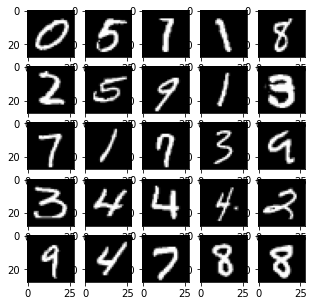

In [0]:
import matplotlib.pyplot as plt

fig,axes=plt.subplots(5,5,figsize=(5,5))

for r in range(5):
    for c in range(5):
        axes[r,c].imshow(X_train[np.random.randint(X_train.shape[0])],cmap='gray')
        

In [0]:
img_shape = (28, 28, 1)
latent_dim = 100

**Generator creation**

In [0]:
def generator():
    model = Sequential()
    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=latent_dim))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))
    model.summary()
    noise = Input(shape=(latent_dim,))
    image = model(noise)
    return Model(noise, image)

**discriminator creation**

In [0]:
def discriminator():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0, 1), (0, 1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.summary()
    image = Input(shape=img_shape)
    validity = model(image)
    return Model(image, validity)

In [0]:
optimizer = Adam(0.0002, 0.5)
channels=1

In [0]:

# build discriminator
discriminator = discriminator()
discriminator.compile(loss='binary_crossentropy',
                      optimizer=optimizer,
                      metrics=['accuracy'])

# build generator
generator = generator()
gen1 = Input(shape=(100,))
img = generator(gen1)

# For the combined model we will only train the generator
discriminator.trainable = False

# The discriminator takes generated images as input and determines validity
valid = discriminator(img)

# The combined model 

combinedModel = Model(gen1, valid)
combinedModel.compile(loss='binary_crossentropy', optimizer=optimizer)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.







Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 64)          256  

**ModelTrainFunction**

In [0]:
def ModelTrain(e, batch_size, save_interval):
    (X_train, _), (_, _) = mnist.load_data()
    # Rescale -1 to 1
    X_train = X_train / 127.5 - 1.
    X_train = np.expand_dims(X_train, axis=3)

    
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(e):
        # Select a random real images
    
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_imgs = X_train[idx]

        # Sample noise and generate a batch of fake images
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_imgs = generator.predict(noise)

        # Train the discriminator
        D_loss_real = discriminator.train_on_batch(real_imgs, valid)
        D_loss_fake = discriminator.train_on_batch(fake_imgs, fake)
        D_loss = 0.5 * np.add(D_loss_real, D_loss_fake)

        # Train the generator
        g_loss = combinedModel.train_on_batch(noise, valid)

        # If at save interval
        if epoch % save_interval == 0:
            # Print the progress
            print("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, D_loss[0], 100 * D_loss[1], g_loss))
            # Save generated image samples
            Image_display(epoch)
   

Display a sample of generated image after interval

In [0]:
def Image_display(epoch):
    noise = np.random.normal(0, 1, (25, latent_dim))
    generated_image = generator.predict(noise)

    # Rescale images 0 - 1
    generated_image = 0.5 * generated_image + 0.5

    fig, axs = plt.subplots(5, 5)
    cnt = 0
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(generated_image[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
  

First train on 1000 epochs and display every 100 epoch

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 1.137170, acc.: 35.94%] [G loss: 1.235968]


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


100 [D loss: 0.875336, acc.: 50.00%] [G loss: 0.973584]
200 [D loss: 0.968515, acc.: 42.19%] [G loss: 1.136642]
300 [D loss: 0.869524, acc.: 39.06%] [G loss: 0.982072]
400 [D loss: 0.777447, acc.: 53.12%] [G loss: 0.999875]
500 [D loss: 0.849529, acc.: 43.75%] [G loss: 0.921888]
600 [D loss: 0.767439, acc.: 50.00%] [G loss: 0.987059]
700 [D loss: 0.697675, acc.: 56.25%] [G loss: 0.999222]
800 [D loss: 0.620161, acc.: 60.94%] [G loss: 1.069445]
900 [D loss: 0.681489, acc.: 56.25%] [G loss: 1.051194]


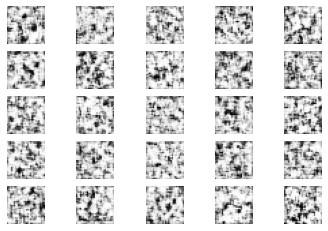

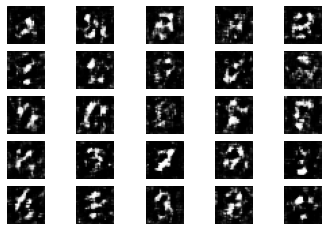

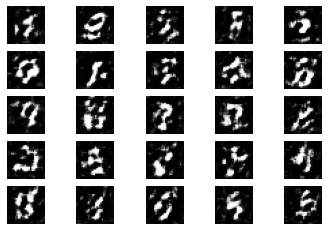

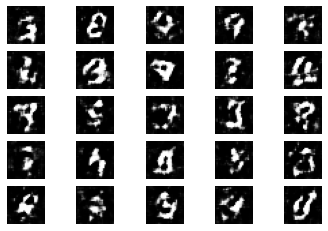

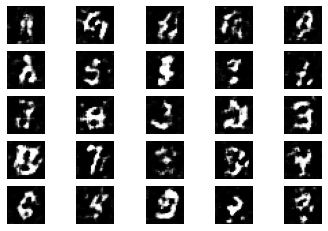

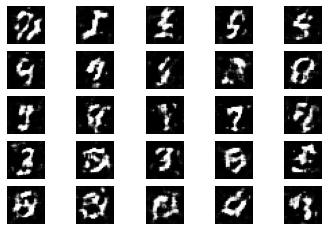

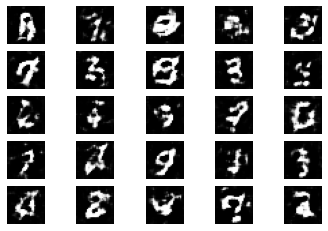

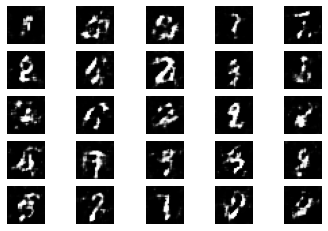

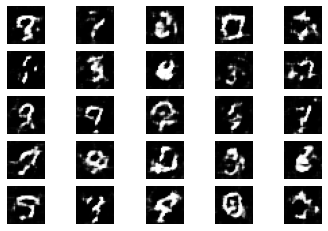

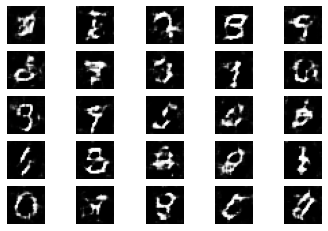

In [0]:
ModelTrain(e=1000, batch_size=32, save_interval=100)


training for 9000 epoch more and dispalaying image in 1000 interval

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.629622, acc.: 65.62%] [G loss: 0.912964]
1000 [D loss: 0.751447, acc.: 51.56%] [G loss: 0.977243]
2000 [D loss: 0.680655, acc.: 59.38%] [G loss: 1.042880]
3000 [D loss: 0.661277, acc.: 64.06%] [G loss: 0.924015]
4000 [D loss: 0.594455, acc.: 70.31%] [G loss: 0.987853]
5000 [D loss: 0.727102, acc.: 51.56%] [G loss: 1.025219]
6000 [D loss: 0.686800, acc.: 59.38%] [G loss: 1.059424]
7000 [D loss: 0.759097, acc.: 53.12%] [G loss: 0.949903]
8000 [D loss: 0.629720, acc.: 64.06%] [G loss: 0.720400]


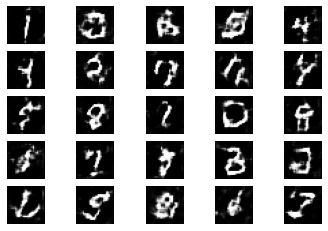

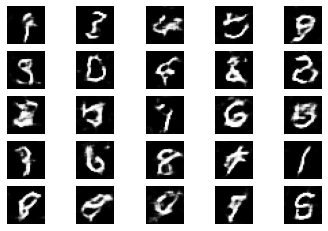

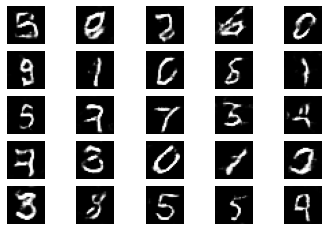

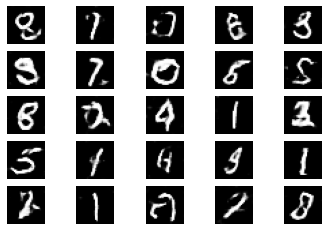

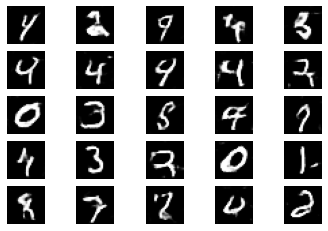

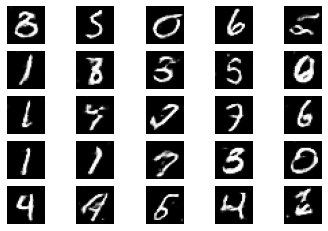

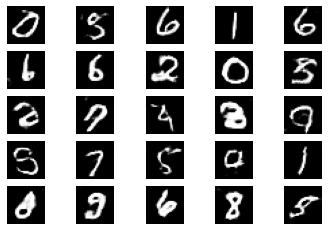

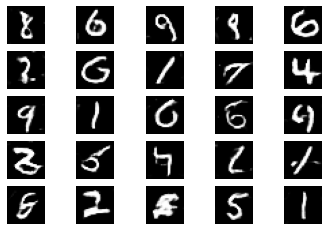

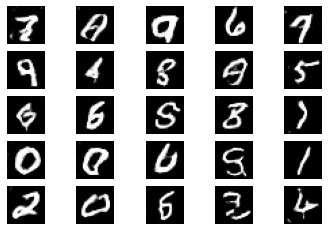

In [0]:

ModelTrain(e=9000, batch_size=32, save_interval=1000)


training for 50000 epoch more and dispalaying image in 5000 interval

/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:493: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [D loss: 0.625116, acc.: 64.06%] [G loss: 0.862208]
5000 [D loss: 0.553779, acc.: 71.88%] [G loss: 1.213228]
10000 [D loss: 0.539643, acc.: 68.75%] [G loss: 1.691593]
15000 [D loss: 0.700947, acc.: 53.12%] [G loss: 0.990925]
20000 [D loss: 0.660968, acc.: 67.19%] [G loss: 1.508504]
25000 [D loss: 0.758263, acc.: 50.00%] [G loss: 1.239944]
30000 [D loss: 0.628497, acc.: 64.06%] [G loss: 0.834289]
35000 [D loss: 0.727920, acc.: 59.38%] [G loss: 1.064282]
40000 [D loss: 0.746073, acc.: 57.81%] [G loss: 1.117906]
45000 [D loss: 0.340904, acc.: 92.19%] [G loss: 1.033074]


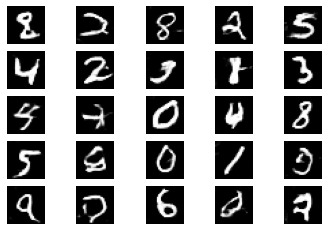

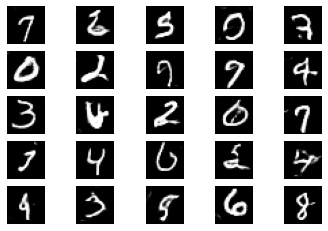

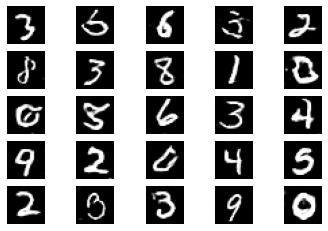

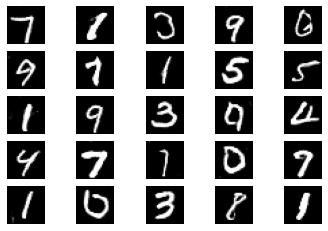

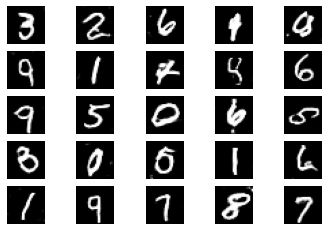

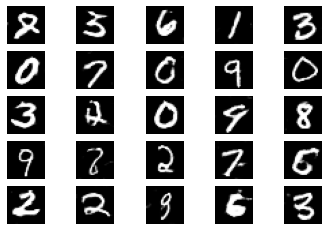

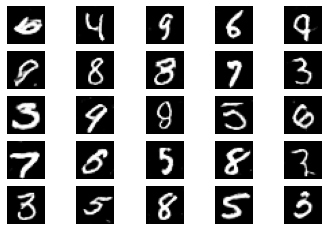

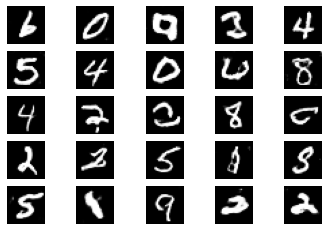

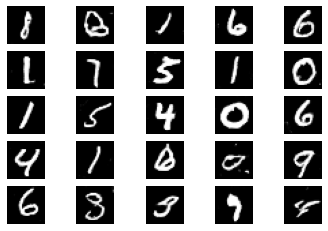

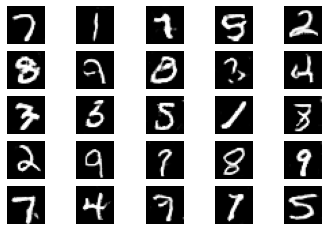

In [0]:
ModelTrain(e=50000, batch_size=32, save_interval=5000)

In [0]:
#Generating a fake image 
import random
random.seed(0)
noise = np.random.normal(0, 1, (1, latent_dim))
fake_imgs = generator.predict(noise)
fake_imgs = fake_imgs.reshape((28, 28))

checking the Structural Similarity Index (SSIM)  of a fake image with first 20 real images of dataset

In [0]:
import cv2
from skimage import measure
score1=0

for i in range(20):
  real_img = X_train[i]
  real_imgsY = Y_train[i]
  image1=real_img
  image2=fake_imgs
  score, diff = measure.compare_ssim(image1, image2, full=True)
  #print(real_imgsY)
  if score1 < score :
     score1=score
   
print("Highest SSIM: {}".format(score1))



Highest SSIM: 0.5103688497569834


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)
